In [4]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
import yfinance as yf

# Reddit API credentials
reddit = praw.Reddit(
    client_id='O9LI6NNjKCFi58JJAIBWyA',
    client_secret='Vhk9wXiLpu6gridgncxxmDGvbVTeuw',
    user_agent='Awkward_Key6792'
)

# Subreddits and keywords to scrape
subreddits = ['wallstreetbets', 'stocks', 'investing', 'apple']
keywords = ['AAPL', 'Apple stock', 'Apple']

# Store data
post_data = []

# Collect data from specified subreddits
for subreddit in subreddits:
    sub = reddit.subreddit(subreddit)
    posts = sub.top(limit=500)
    for post in posts:
        post_data.append([post.created_utc, post.title, post.selftext, post.score, subreddit])

# Collect data using keywords
for keyword in keywords:
    posts = reddit.subreddit('all').search(keyword, sort='top', limit=500)
    for post in posts:
        post_data.append([post.created_utc, post.title, post.selftext, post.score, post.subreddit.display_name])

# Save to DataFrame
df = pd.DataFrame(post_data, columns=['Timestamp', 'Title', 'Body', 'Score', 'Subreddit'])
df.to_csv('reddit_stock_data.csv', index=False)

print("Data collection complete. Posts saved to reddit_stock_data.csv.")
print(df.isnull().sum())

# Fetch stock data for Apple
stock_data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
stock_data.reset_index(inplace=True)
stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.date
stock_data.to_csv('apple_stock_data.csv', index=False)
print("Stock data fetched and saved to apple_stock_data.csv.")

# Load stock data
stock_data = pd.read_csv('apple_stock_data.csv')
print(stock_data.head())  # Check the stock data

# Convert timestamps to datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Sentiment Analysis Function
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Clean and analyze sentiment
df['Body'] = df['Body'].fillna('')
df['Sentiment'] = df['Body'].apply(get_sentiment)

# Group by date and average sentiment
daily_sentiment = df.groupby(df['Timestamp'].dt.date)['Sentiment'].mean().reset_index()
daily_sentiment.rename(columns={'Timestamp': 'Date'}, inplace=True)

# Convert the Date column in daily_sentiment to datetime
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

# Merge sentiment data with stock price data
combined_data = pd.merge(daily_sentiment, stock_data, on='Date', how='inner')
print(combined_data.head())  # Debug: Check the combined data

# Check for empty DataFrame
if combined_data.empty:
    print("Combined DataFrame is empty. Check the merge keys or input data.")
else:
    # Plot sentiment and stock price over time
    plt.figure(figsize=(12, 6))
    plt.plot(combined_data['Date'], combined_data['Close'], label='Stock Price', color='blue')
    plt.scatter(combined_data['Date'], combined_data['Sentiment'], label='Average Sentiment', color='orange', alpha=0.5)
    plt.title('Apple Stock Price and Sentiment Analysis (2020-2024)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()
    plt.show()


Data collection complete. Posts saved to reddit_stock_data.csv.
Timestamp    0
Title        0
Body         0
Score        0
Subreddit    0
dtype: int64


[*********************100%***********************]  1 of 1 completed


Stock data fetched and saved to apple_stock_data.csv.
         Date       Open       High        Low      Close  Adj Close  \
0  2020-01-02  74.059998  75.150002  73.797501  75.087502  72.876099   
1  2020-01-03  74.287498  75.144997  74.125000  74.357498  72.167633   
2  2020-01-06  73.447502  74.989998  73.187500  74.949997  72.742653   
3  2020-01-07  74.959999  75.224998  74.370003  74.597504  72.400551   
4  2020-01-08  74.290001  76.110001  74.290001  75.797501  73.565216   

      Volume  
0  135480400  
1  146322800  
2  118387200  
3  108872000  
4  132079200  


ValueError: You are trying to merge on datetime64[ns] and object columns. If you wish to proceed you should use pd.concat

In [7]:
# Load stock data
stock_data = pd.read_csv('apple_stock_data.csv')

# Convert the Date column in stock_data to datetime
stock_data['Date'] = pd.to_datetime(stock_data['Date'], errors='coerce')

# Debug: Check the data types of the Date columns
print("Daily Sentiment Date Type:", daily_sentiment['Date'].dtype)
print("Stock Data Date Type:", stock_data['Date'].dtype)

# Merge sentiment data with stock price data
combined_data = pd.merge(daily_sentiment, stock_data, on='Date', how='inner')
print(combined_data.head())  # Debug: Check the combined data


Daily Sentiment Date Type: datetime64[ns]
Stock Data Date Type: datetime64[ns]
        Date  Sentiment       Open       High        Low      Close  \
0 2020-01-02   0.000000  74.059998  75.150002  73.797501  75.087502   
1 2020-01-03   0.087500  74.287498  75.144997  74.125000  74.357498   
2 2020-01-06   0.000000  73.447502  74.989998  73.187500  74.949997   
3 2020-01-07   0.022513  74.959999  75.224998  74.370003  74.597504   
4 2020-01-08   0.087500  74.290001  76.110001  74.290001  75.797501   

   Adj Close     Volume  
0  72.876099  135480400  
1  72.167633  146322800  
2  72.742653  118387200  
3  72.400551  108872000  
4  73.565216  132079200  


NaN values in 'Close': 0
NaN values in 'Sentiment': 0


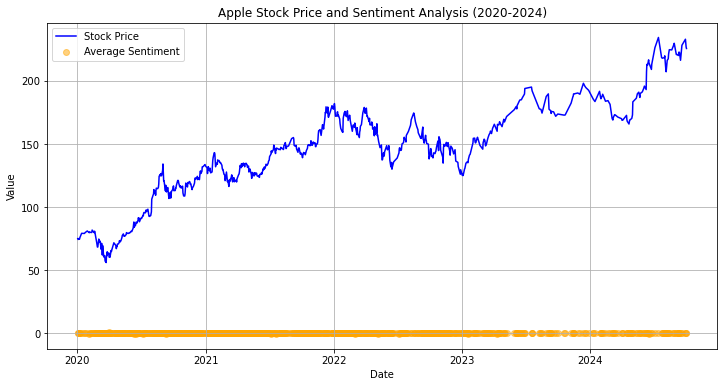

In [10]:
# Check for NaN values in the columns to be plotted
print("NaN values in 'Close':", combined_data['Close'].isna().sum())
print("NaN values in 'Sentiment':", combined_data['Sentiment'].isna().sum())

# Optionally drop rows with NaN values
combined_data = combined_data.dropna(subset=['Close', 'Sentiment'])

# Plot sentiment and stock price over time
plt.figure(figsize=(12, 6))
plt.plot(combined_data['Date'].values, combined_data['Close'].values, label='Stock Price', color='blue')
plt.scatter(combined_data['Date'].values, combined_data['Sentiment'].values, label='Average Sentiment', color='orange', alpha=0.5)
plt.title('Apple Stock Price and Sentiment Analysis (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()


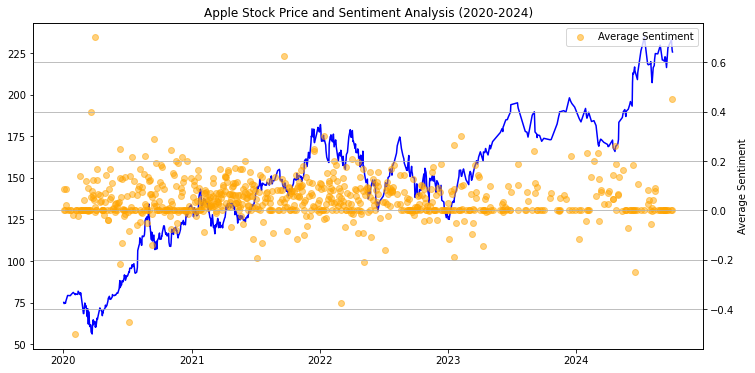

In [12]:
# Plot sentiment and stock price over time with a secondary y-axis
plt.figure(figsize=(12, 6))

# Primary y-axis for stock price
plt.plot(combined_data['Date'].values, combined_data['Close'].values, label='Stock Price', color='blue')

# Create a secondary y-axis for sentiment
ax2 = plt.gca().twinx()  # Instantiate a second axes that shares the same x-axis
ax2.scatter(combined_data['Date'].values, combined_data['Sentiment'].values, label='Average Sentiment', color='orange', alpha=0.5)

# Adding titles and labels
plt.title('Apple Stock Price and Sentiment Analysis (2020-2024)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
ax2.set_ylabel('Average Sentiment')

# Adding legends
plt.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show grid
plt.grid()

# Show the plot
plt.show()


In [16]:
# Assuming combined_data is your merged DataFrame
correlation = combined_data['Sentiment'].corr(combined_data['Close'])
print(f"Correlation between Sentiment and Stock Price: {correlation:.2f}")


Correlation between Sentiment and Stock Price: 0.00


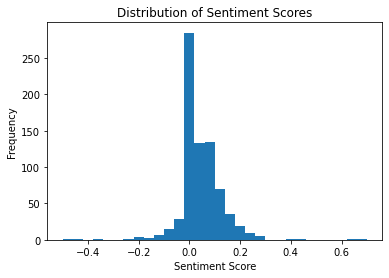

In [18]:
plt.hist(combined_data['Sentiment'], bins=30)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()
